# N-Gram Language Model

### A. Library Tools

In [2]:
import nltk
from nltk.corpus import brown

In [3]:
brown_bigram_cfd = nltk.ConditionalFreqDist(nltk.bigrams(brown.words()))
    # type: dict.
    # structure:
    #  keys = words; values = dict of next_word:frequency.

In [10]:
brown_bigram_cpd = nltk.ConditionalProbDist(brown_bigram_cfd, nltk.MLEProbDist)

In [20]:
brown_bigram_cpd['my'] # 'my' has 1161 next words in total.

<MLEProbDist based on 1161 samples>

In [25]:
brown_bigram_cpd['my'].prob('own') # p(w_i+1=own | w_i=my)

0.04478897502153316

### B. N-Gram LMs

**NB: In practice, GT-smoothing is used with Linear Interpolation (e.g. $\hat(p)(w_n|w_{n-2}w_{n-1}) = \lambda_1p(w_n|w_{n-2}w_{n-1}) + \lambda_2p(w_n|w_{n-1}) + \lambda_3p(w_n)$), where $\lambda$ weights are learned using EM algorithm. This is not implemented here because EM algorithm will be implemented later on.**

In [1]:
import nltk

In [2]:
def load_brown(train_percentage=.8):
    from nltk.corpus import brown
    from nltk.stem import PorterStemmer
    print "... loading sentences"
    brown_sents = brown.sents()
    print "... stemming and lowercasing words"
    brown_sents = [[PorterStemmer().stem(w).lower() for w in sent]
                   for sent in brown_sents]
    print "... padding sentences"
    brown_sents = [['<s>']+s+['</s>'] for s in brown_sents]
    cut_off = int(len(brown_sents)*.8)
    
    return ([w for s in brown_sents[:cut_off] for w in s], \
            brown_sents[cut_off:]) # train: a list of words; test: a list of sents.

In [3]:
%%time
brown_train, brown_test = load_brown()
print brown_train[0]

... loading sentences
... stemming and lowercasing words
... padding sentences
<s>
CPU times: user 21.3 s, sys: 266 ms, total: 21.5 s
Wall time: 21.7 s


In [132]:
import numpy as np
from nltk.util import ngrams
from collections import Counter, defaultdict
from functools import partial
from __future__ import division

In [133]:
from sklearn.linear_model import LinearRegression

In [170]:
class NGramLM:
    
    def __init__(self, train, test, n=2):
        self.train = train # a list of words.
        self.test = test # a list of lists of words (i.e. a list of splitted sents).
        self.n = n
        self.vocab = list(set(train))
        test_vocab = {w for s in self.test for w in s}
        self.unseen_vocab = test_vocab - test_vocab.intersection(set(self.vocab))
        self.N = len(train)
        self.V = len(self.vocab)
        self.build_n_grams()
        
    def build_n_grams(self):
        n_grams = {} 
        N_cs, gt_lrs = {}, {}
            # N_cs: a dictionary of n-gram frequency of frequency (good-turing).
            #  keys: N_cs[2], e.g., for N_c distribution of bigrams.
            # gt_lrs: linear regression: log(N_c) = intercept + coef * log(c).
            #  handles N_c = 0 cases (Gale & Sampson 1995).
            #  keys: gt_lrs[2] returns the function that takes a count c,
            #        and returns an estimated N_c.
        for i in xrange(1,self.n+1):
            n_grams[i] = Counter(ngrams(self.train,i)) 
            N_c = defaultdict(int) # N_c: keys=freq; values=freq of freq.
            for freq in n_grams[i].values():
                N_c[freq] += 1
            N_cs[i] = N_c
            lr = LinearRegression()
            lr.fit(np.log(N_c.keys())[:,np.newaxis],np.log(N_c.values())[:,np.newaxis])
            gt_lrs[i] = lambda c: np.exp(lr.intercept_[0] + lr.coef_[0][0]*np.log(c))
                # log(N_c) = intercept + coef * log(c) =>
                # N_c = exp( intercept + coef * log(c) ) (cf. J&M ch4.5:21,eq.4.29).
        self.n_grams = n_grams
        self.N_cs = N_cs
        self.gt_lrs = gt_lrs             
        
    def adjusted_count(self, ngram, smoothing='laplace'): # ngram: a list of words, e.g. ['my','pencil'].
        n = len(ngram)
        c = self.n_grams[n][tuple(ngram)]
        if smoothing=='laplace':
            c_adjusted = self.laplace_adjust(c)
        else: 
            c_adjusted = self.good_turing_adjust(c,n)      
        return c_adjusted
    
    def laplace_adjust(self, c):
        return (c+1)*(self.N/(self.N+self.V)) # (cf. J&M ch4.5:17,eq.4.21)
    
    def get_N_c(self, c, n):
        N_c = 0 if c not in self.N_cs[n].keys() else self.N_cs[n][c]
            # accessing N_cs[n][c] when it doesn't exist would make a 0 entry at N_cs[n][c],
            #  because N_cs[n] is set as a defaultdict(int) for computational convenience.
        if N_c==0:
            return self.gt_lrs[n](c)
        return N_c
    
    def good_turing_adjust(self, c, n): # n for n in 'n'-gram
        k = 5 # Katz correction (Katz 1987)
        if c==0: 
            N_0 = self.get_N_c(1,n) # N_1 for N_0, moved prob. mass = N_1/N (cf. J&M ch4.5:20,eq.4.25) 
            return N_0 * (1/len(self.unseen_vocab))
                # prob(w_unseen) = (N_1/N)*(1/unseen_vocab_size) = (N_1*(1/unseen_vocab_size)) / N,
                #  so instead of returning N_1 for count, we multiply it by (1/unseen_vocab_size)
                #  as a special case (i.e. 0-count case) treatment.
                #  logically this is returning a count, but computationally it adds up.
        elif c>=1 and c<=k:
            return ( (c+1)*(self.get_N_c(c+1,n)/self.get_N_c(c,n)) / \
                     1 - ( (k+1)*self.get_N_c(k+1,n) ) / self.get_N_c(1,n) ) # (cf. J&M ch4.5:21,eq.4.31)
        else:
            return (c+1)*(self.get_N_c(c+1,n)/self.get_N_c(c,n))
    
    def n_gram_probability(self, sent, n=1, smoothing='laplace'):
        p = 1
        for i in xrange(1,n): # special case handling, e.g, (w_i | w_i-2,w_i-1) = (w_i), etc.
            if i==1:
                p *= self.adjusted_count(sent[:i],smoothing)/self.N
            else:
                p *= self.adjusted_count(sent[:i],smoothing)/self.adjusted_count(sent[:i-1],smoothing)
        n_grams = list(ngrams(sent,n))
        for n_gram in n_grams:
            if n==1:
                p *= self.adjusted_count(n_gram,smoothing)/self.N
            else:
                p *= self.adjusted_count(n_gram,smoothing)/self.adjusted_count(n_gram[:-1],smoothing)
        return p if p>0 else 1e-323 # if still underflow, return the smallest number possible.
    
    def perplexity(self, sent, n=1, smoothing='laplace'):
        N = len(sent)
        p = self.n_gram_probability(sent,n,smoothing)
        return np.exp(-(1/N)*np.log(p))
            # more likely returning np.power(p,-1/N) exposes us to 
            #  underflow issue (cf. J&M ch4.8:26,eq.4.45)
            # np.exp(-(1/N)*np.log(p)) is LESS LIKELY to have this issue.

    def evaluate(self, n=1, smoothing='laplace'):
        return np.mean([self.perplexity(sent,n,smoothing) for sent in self.test])

# smoothing variable passing pipeline:
# 
# perplexity() --> n_gram_probability() --> adjusted_count() 
#     |\        
#     |     
# evaluate() 

In [171]:
%%time
nglm = NGramLM(brown_train,brown_test,n=6)

CPU times: user 7.78 s, sys: 151 ms, total: 7.93 s
Wall time: 7.99 s


##### GT-smoothing has lower average perplexity over ngrams than Laplace-smoothing
**NB: unigram doesn't care about dependency at all, so its perplexity is not a good evaluator for comparing language models.**

**NB: GT-smoothing here doesn't have Linear Interpolation accompany it, so perplexity increases as the size of ngram increases. However the point of this demo is only to show that GT-smoothing has lower avg. perplexity.**

In [173]:
%%time
print 'Laplace Smoothing:'
for i in xrange(2,6+1):
    print '... %d-gram Average Perplexity: %.6f' % (i,nglm.evaluate(n=i,smoothing='laplace'))

Laplace Smoothing:
... 2-gram Average Perplexity: 61.502261
... 3-gram Average Perplexity: 9.536523
... 4-gram Average Perplexity: 4.197516
... 5-gram Average Perplexity: 3.661287
... 6-gram Average Perplexity: 3.602977
CPU times: user 3.41 s, sys: 72.2 ms, total: 3.48 s
Wall time: 3.43 s


In [174]:
%%time
print 'Good-Turing Smoothing:'
for i in xrange(2,6+1):
    print '... %d-gram Average Perplexity: %.6f' % (i,nglm.evaluate(n=i,smoothing='good-turing'))

Good-Turing Smoothing:
... 2-gram Average Perplexity: 1.138796
... 3-gram Average Perplexity: 1.716055
... 4-gram Average Perplexity: 1.499161
... 5-gram Average Perplexity: 1.884957
... 6-gram Average Perplexity: 2.056255
CPU times: user 24.7 s, sys: 812 ms, total: 25.5 s
Wall time: 24.9 s


##### Demo: How GT-smoothing with Linear Regression works

In [144]:
print nglm.N_cs[6] # key=freq (for 6-grams); value=freq of freq.

defaultdict(<type 'int'>, {1: 1035401, 2: 9414, 3: 1720, 4: 647, 5: 347, 6: 180, 7: 154, 8: 69, 9: 38, 10: 35, 11: 34, 12: 15, 13: 26, 14: 23, 15: 10, 16: 17, 17: 6, 18: 8, 19: 12, 20: 7, 21: 2, 22: 4, 23: 2, 24: 3, 25: 3, 26: 2, 27: 2, 29: 3, 30: 2, 31: 1, 32: 1, 33: 1, 34: 5, 35: 1, 36: 3, 37: 3, 38: 2, 40: 2, 43: 1, 44: 2, 49: 3, 51: 1, 52: 1, 53: 2, 55: 1, 63: 1, 164: 1})


In [145]:
c_vec = nglm.N_cs[6].keys() 
N_c_vec = nglm.N_cs[6].values() 
print c_vec
print N_c_vec

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 44, 49, 51, 52, 53, 55, 63, 164]
[1035401, 9414, 1720, 647, 347, 180, 154, 69, 38, 35, 34, 15, 26, 23, 10, 17, 6, 8, 12, 7, 2, 4, 2, 3, 3, 2, 2, 3, 2, 1, 1, 1, 5, 1, 3, 3, 2, 2, 1, 2, 3, 1, 1, 2, 1, 1, 1]


In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

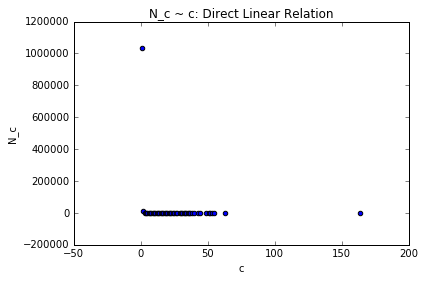

In [147]:
plt.scatter(c_vec,N_c_vec)
plt.title('N_c ~ c: Direct Linear Relation')
plt.xlabel('c')
plt.ylabel('N_c')

In [150]:
log_c_vec, log_N_c_vec = np.log(c_vec), np.log(N_c_vec)
lr = LinearRegression()
lr.fit(log_c_vec[:,np.newaxis],log_N_c_vec[:,np.newaxis])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

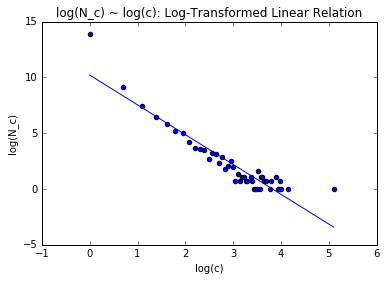

In [156]:
plt.scatter(log_c_vec,log_N_c_vec)
plt.plot(log_c_vec, map(lambda log_c:lr.intercept_[0]+lr.coef_[0][0]*log_c, log_c_vec))
plt.title('log(N_c) ~ log(c): Log-Transformed Linear Relation')
plt.xlabel('log(c)')
plt.ylabel('log(N_c)')